In [499]:
from urllib.request import urlopen
import json
import numpy as np
import pandas as pd
from collections import Counter
import warnings
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
from googletrans import Translator
import enchant
d = enchant.Dict("en_US")

In [595]:
df = pd.read_csv('dados/base.csv',encoding='utf-8',header=1)
grafo = df.drop(['id','title','priority date','inventor/author','filing/creation date','publication date','grant date','result link','representative figure link'],axis=1)
grafo['assignee'].fillna('-',inplace=True)
#grafo['assignee'] = grafo['assignee'].apply(lambda x: traduzir(x))
grafo.head()

,assignee
0,Gen Electric
1,Gen Electric
2,Arcam Ab
3,General Electric Company
4,Boeing Co


In [614]:
def numero_invencoes(nome):
    try:
        return len(pd.DataFrame(df[df['assignee'].str.contains(nome)]['assignee']))
    except:
        return 1
maximo=0
def get_nodes_and_edges():
    df['assignee'].fillna('Não especificado', inplace=True)
    nodes = pd.DataFrame()
    edges = pd.DataFrame()
    nomes = df['assignee'].unique()
    novo_nomes = []
    duplas = []
    num_inventores = 1
    for nome in nomes:
        inventores = nome.split(', ')
        if len(inventores)> 1:
            for inventor in inventores:
                if not inventor in 'Inc. Inc Ltd. Ltd Llc. Llc Com. Com Limited Company Corp Corp. SA Sa S.A.'.split(' '):
                    novo_nomes.append(inventor)
                    num_inventores += 1
                else:
                    num_inventores -= 1
            if num_inventores > 1:
                duplas += get_duplas(inventores)
                
        else:
            novo_nomes.append(nome)
    count_duplas = list(dict(Counter(duplas)).values())
    duplas_unicas = list(dict(Counter(duplas)).keys())
    maximo = max(count_duplas)
    sources = []
    targets = []
    for source,target in duplas_unicas:
        sources.append(source)
        targets.append(target)

    edges['source'] = sources
    edges['target'] = targets
    edges['value'] = list(map(lambda x: float(maximo)/float(int(x)),count_duplas))
    nodes['name'] = pd.Series(novo_nomes).unique()
    nodes['nodesize'] =nodes['name'].apply(lambda x: numero_invencoes(x))
    nodes['group'] = 1
    return nodes,edges

def get_duplas(nomes):
    duplas = []
    for i in range(len(nomes)):
        for j in range(i+1,len(nomes)):
            if not nomes[i] in 'Inc. Inc Ltd. Ltd Llc. Llc Com. Com Limited Company Corp Corp. SA Sa S.A.'.split(' ') and not nomes[j] in 'Inc. Ltd. Llc. Llc'.split(' '):
                duplas.append((nomes[i],nomes[j]))
    return duplas

def traduzir(palavra):
    print(palavra)
    if not d.check(palavra):
        return translator.translate(palavra,dest='en').text
    else:
        return palavra
        

In [615]:
nodes_df,edges_df = get_nodes_and_edges()
nodes_df = nodes_df[nodes_df['name'] != 'Não especificado']

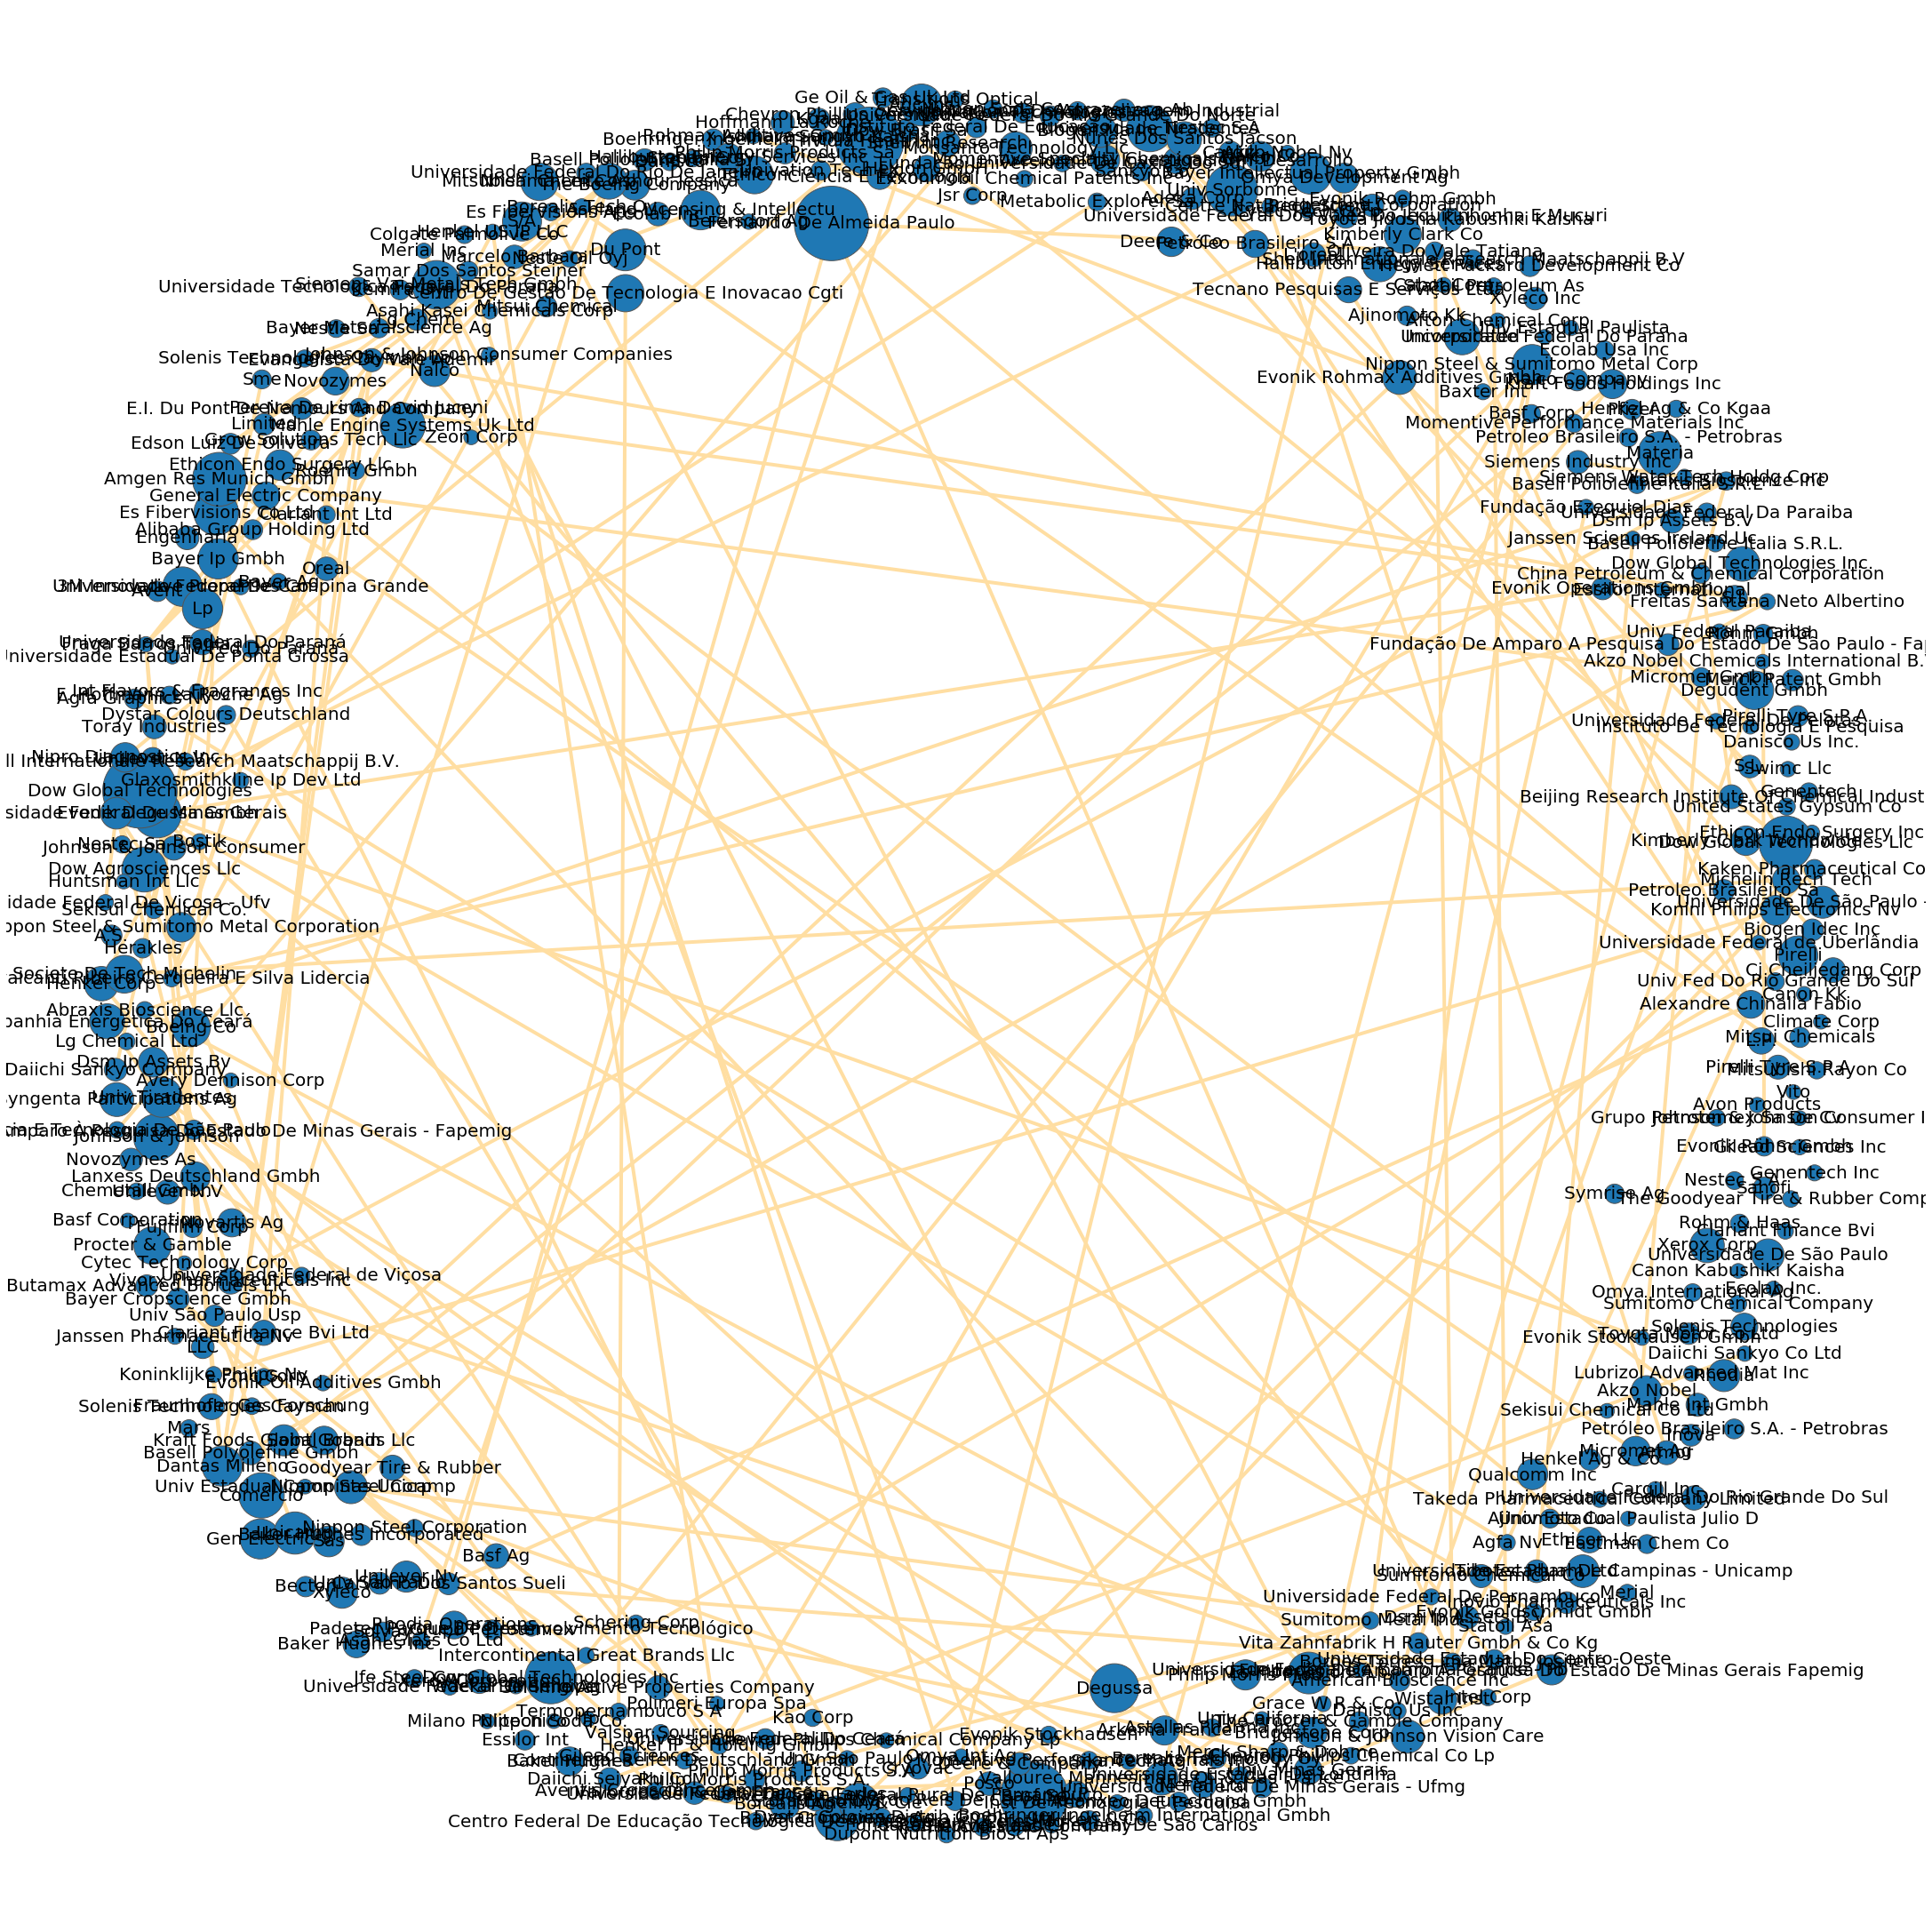

In [640]:
warnings.filterwarnings('ignore')

G = nx.Graph()
edges_grafo = pd.DataFrame(edges_df[edges_df['value']<edges_df['value'].max()])
nodes_grafo = pd.DataFrame(nodes_df[nodes_df['nodesize'] > 10])


for index, row in nodes_grafo.iterrows():
    G.add_node(row['name'], group=row['group'], nodesize=5*row['nodesize'])
    
for index, row in edges_grafo.iterrows():
    G.add_weighted_edges_from([(row['source'], row['target'], row['value'])])
    
color_map = {1:'f09494', 2:'eebcbc', 3:'72bbd0', 4:'91f0a1'} 
plt.figure(figsize=(30,30))
options = {
    'edge_color': '#FFDEA2',
    'width': 4,
    'with_labels': True,
    'font_weight': 'regular',
    'font_size': 20
}

sizes = []

for node in G:
    try: 
        if G.nodes[node]!={}:
            sizes.append(G.nodes[node]['nodesize']*5)
    except: 
        pass

nx.draw(G, node_size=sizes, pos=nx.spring_layout(G, k=5), **options)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555") 
plt.savefig('visualização/grafos.png')

plt.show()